# Abagail 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '/Users/andrew/Documents/Lab/aas/Hera/modules'))
from NN_helpers import *
from aas_neural_networks import *
from NN_results_helpers import *
import sigchain 

from IPython.display import Image, display

***
## Generate data

In [8]:
# constants
num_entries = 10000
num_channels = 1024

tau_low = -0.01
tau_high = 0.01

nu = np.arange(0, num_channels)

##### Clean data

In [9]:
# # random.uniform is half open [low, high) not sure if that matters
# tau = np.random.uniform(low = tau_low, high = tau_high, size = num_entries) 
# phi = np.random.uniform(low = 0, high = 2*np.pi, size =  num_entries)

# data = np.empty((num_entries, num_channels), dtype = np.complex128)
# for i in range(num_entries):
#     data[i]    = np.exp(2*np.pi*1j * (tau[i]*nu + phi[i]))
    
# clean_phase_data = np.empty((num_entries, num_channels))
# for i in range(num_entries):
#     clean_phase_data[i] = np.angle(data[i])
    
# np.savez('data/clean_phase_data.npz', tau, clean_phase_data)

##### Clean data with crosstalk applied

In [10]:
# # random.uniform is half open [low, high) not sure if that matters
# tau = np.random.uniform(low = tau_low, high = tau_high, size = num_entries) 
# phi = np.random.uniform(low = 0, high = 2*np.pi, size =  num_entries)

# data = np.empty((num_entries, num_channels), dtype = np.complex128)
# for i in range(num_entries):
#     data[i]    = np.exp(2*np.pi*1j * (tau[i]*nu + phi[i]))
    
# xtalk = np.empty((num_entries, num_channels), dtype = np.complex128)
# for i in range(num_entries):
#     xtalk[i] = sigchain.gen_xtalk(nu, amplitude= 0.05)
    
# phase_data_with_xtalk = np.empty((num_entries, num_channels))
# for i in range(num_entries):
#     phase_data_with_xtalk[i] = np.angle(xtalk[i] + data[i])
    
# np.savez('data/phase_data_with_xtalk.npz', tau, phase_data_with_xtalk)

***
### Load Data

In [11]:
# data = (inputs, ouputs) 
data_clean = load_data('data/clean_phase_data.npz')
data_wxtlk = load_data('data/phase_data_with_xtalk.npz')

#### Take a look

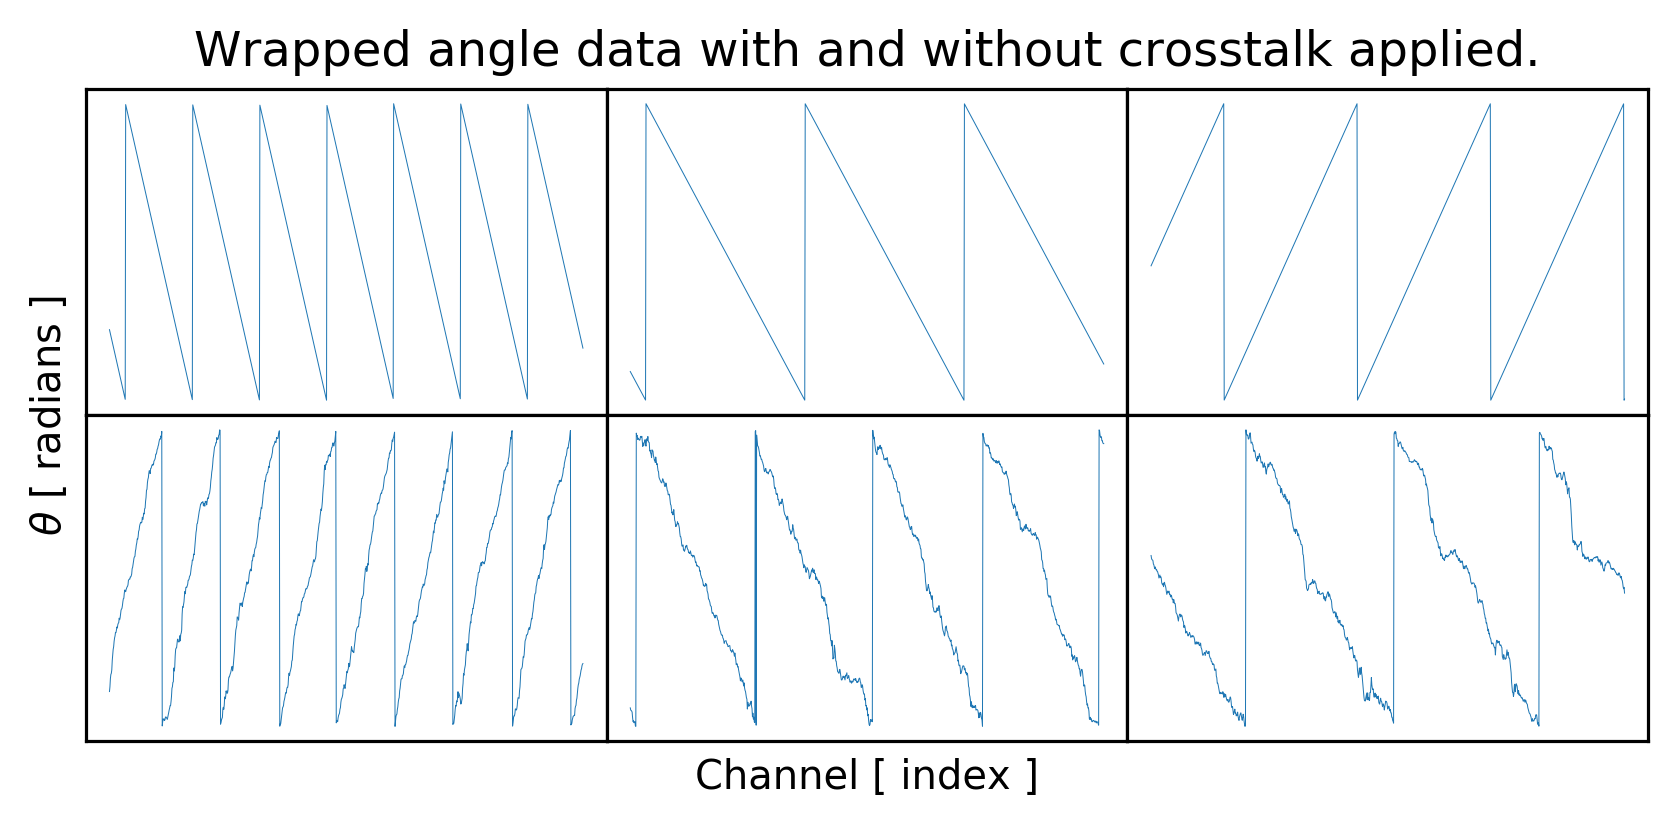

In [12]:
random_entries = np.random.choice(range(data_clean[0].shape[0]), size = 6)

fig, axes = plt.subplots(2,3, figsize = (7, 3), dpi = 144)

for i, ax in enumerate(axes.reshape(-1)):

    if i < 3: ax.plot(nu, data_clean[0][random_entries[i]], linewidth = 0.25)
    if i > 2: ax.plot(nu, data_wxtlk[0][random_entries[i]], linewidth = 0.25)

    ax.set_xticks([])
    ax.set_yticks([])
    
    
axes.reshape(-1)[0].set_ylabel(r'$\theta$ [ radians ]', y = 0)
axes.reshape(-1)[4].set_xlabel('Channel [ index ]')
axes.reshape(-1)[1].set_title('Wrapped angle data with and without crosstalk applied.')
plt.subplots_adjust(hspace = 0, wspace = 0)
plt.show()

***
### Preprocess clean data for training

In [13]:
testing_data_percentage = 0.20

In [14]:
scaled_input, scaled_output, input_scaler, output_scaler = NN_helpers.scale_data(data_clean)
X_train, X_test, y_train, y_test = train_test_split(scaled_input, scaled_output,
                                                test_size = testing_data_percentage,
                                                random_state = np.random.seed(int(time.time())))

### Determine network hyperparameters

In [15]:
# these numbers have to work out with no remainder 
# or we need to truncate the data


# literature says batchsize of 2 to 32 is best. 
batchsize = 32.
num_batches = int(X_train.shape[0] / batchsize)
print(num_batches)

250


In [18]:
number_of_inputs  = X_train.shape[1]
number_of_outputs =  X_test.shape[1]
layer_nodes = [256,128,64]
learning_rate = 0.0001

In [19]:
num_epochs = 200

#### Create Network

In [20]:
Abagail = Sheridan_NN_Two(layer_nodes,number_of_inputs, number_of_outputs, learning_rate)

#### Train Abagail

In [21]:
sheridan_train(X_train, y_train,
               X_test, y_test,
               num_epochs, num_batches,
               Abagail, output_scaler, 'logs/abagail-run-A', keep_prob_rate = 0.50, model_save_interval = 20)

epoch:  199 -- testing_cost: 0.0003975400 -- batch:

###### view in tensorboard: `tensorboard --logdir=logs`

### Review Training

> Abagail trained quickly on this data. With more time I believe cost would have continued decreasing (slowly) for some time.

In [22]:
training_costs, testing_costs = get_costs('logs/',num_epochs)

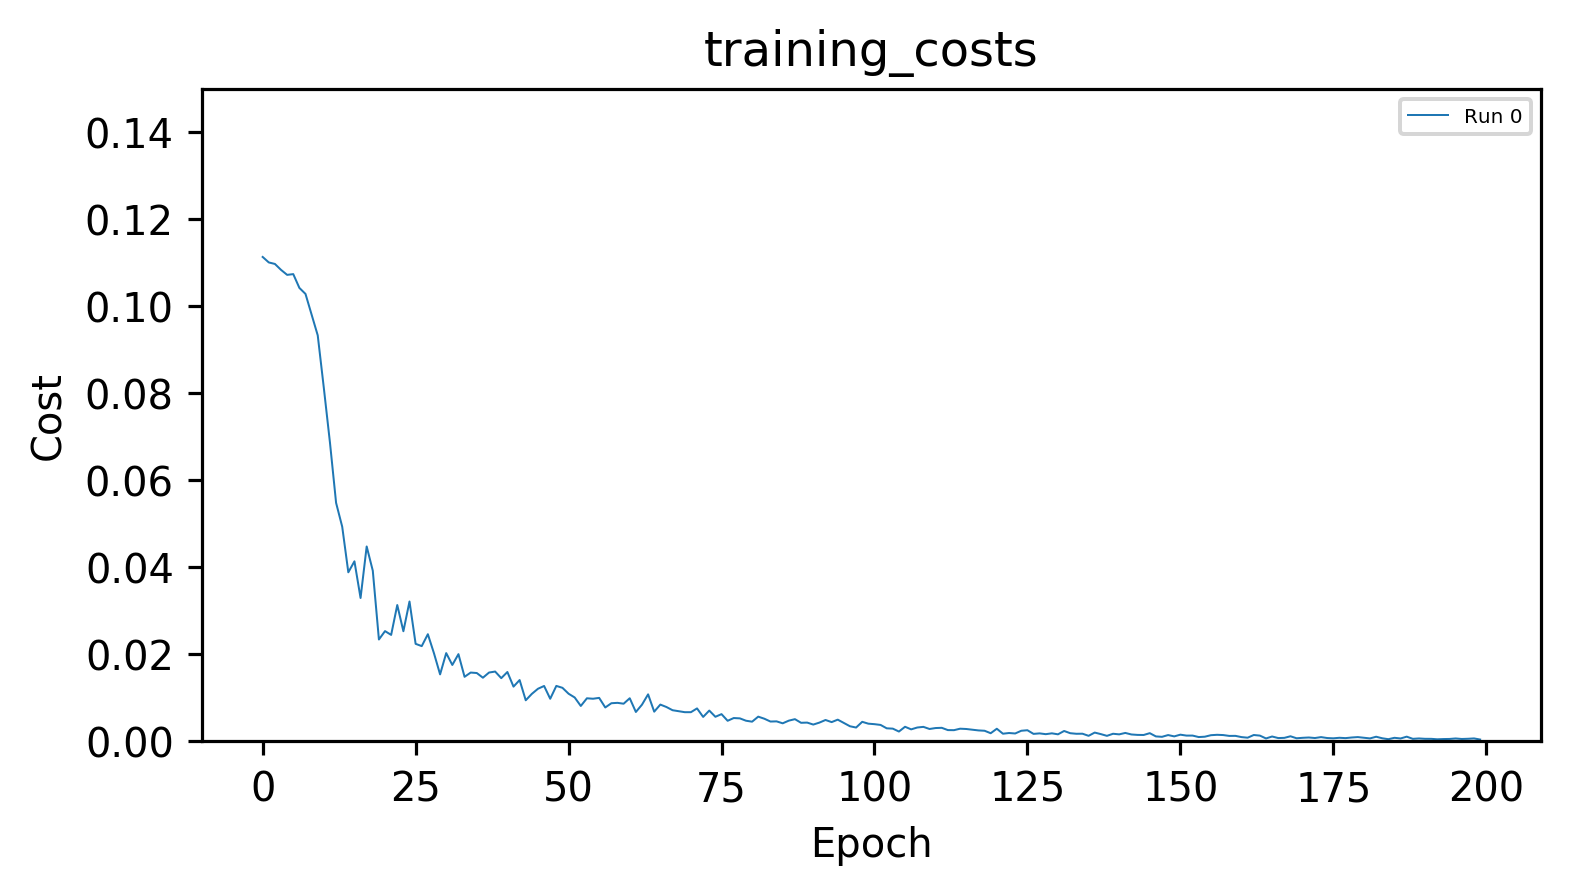

In [24]:
plot_costs(training_costs, 'training_costs', ylim = [0,0.15], highlight_run = 0)

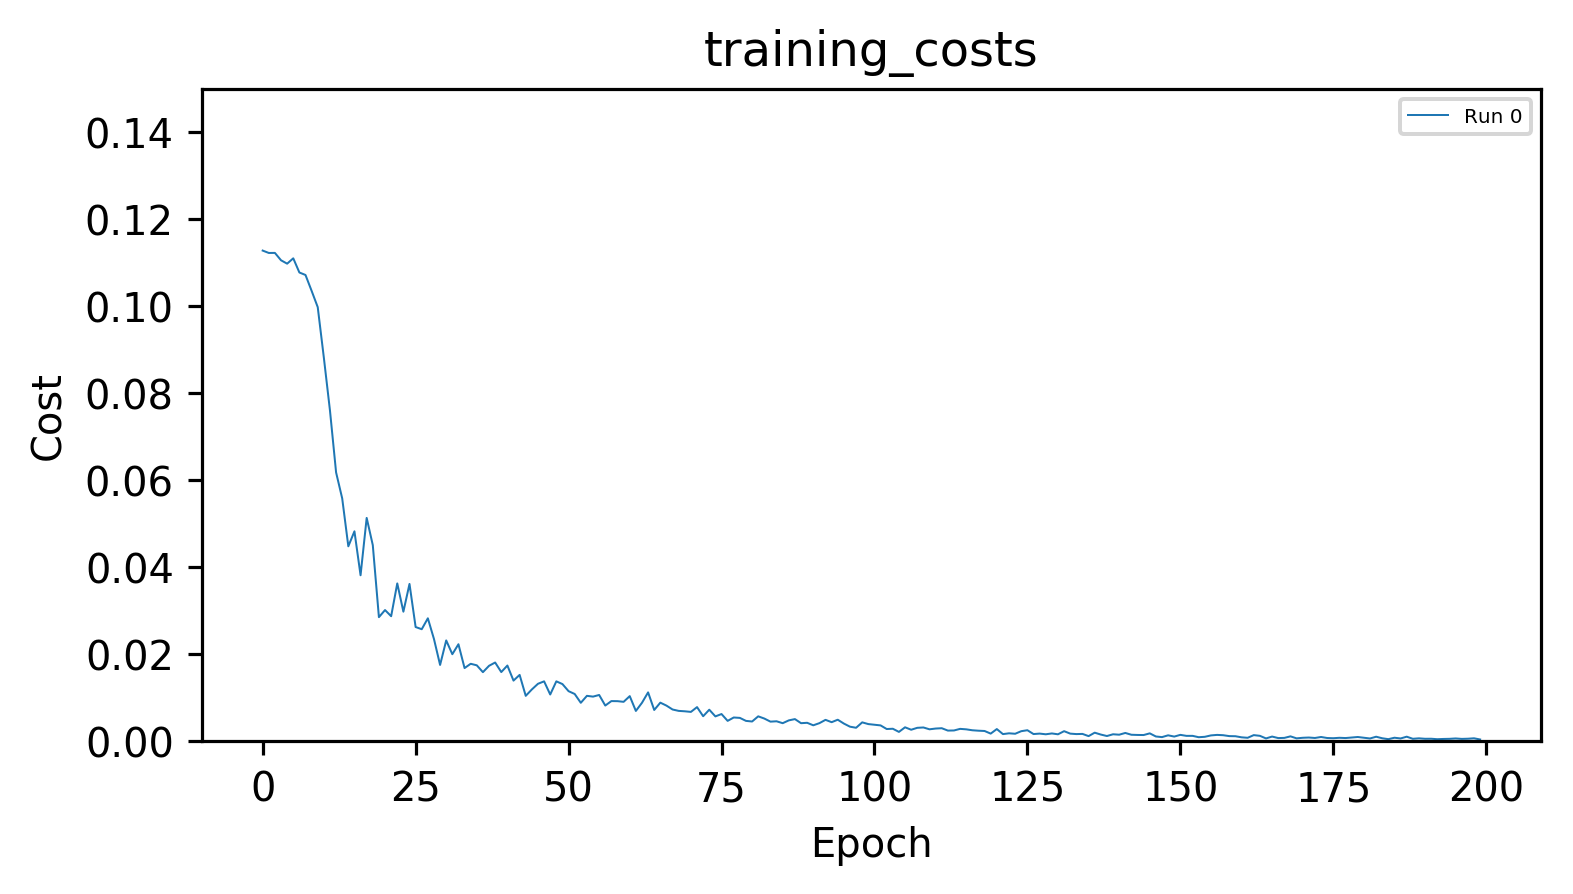

In [25]:
plot_costs(testing_costs, 'training_costs', ylim = [0,0.15], highlight_run = 0)

***
### Preprocess **clean data with crosstalk** for training

In [26]:
testing_data_percentage = 0.20

In [27]:
scaled_input, scaled_output, input_scaler, output_scaler = NN_helpers.scale_data(data_wxtlk)
X_train, X_test, y_train, y_test = train_test_split(scaled_input, scaled_output,
                                                test_size = testing_data_percentage,
                                                random_state = np.random.seed(int(time.time())))

In [28]:
# this data has all the same dimensions as the other so the constnts are the same

#### Train Abagail - Reload saved model from prior training

In [31]:
sheridan_train(X_train, y_train,
               X_test, y_test,
               num_epochs, num_batches,
               Abagail, output_scaler, 'logs/abagail-run-B',
               keep_prob_rate = 0.50, model_save_interval = 20,
               old_model = 'logs/abagail-run-A/trained_model.ckpt-199')

INFO:tensorflow:Restoring parameters from logs/abagail-run-A/trained_model.ckpt-199
epoch:  199 -- testing_cost: 0.0004020207 -- batch:

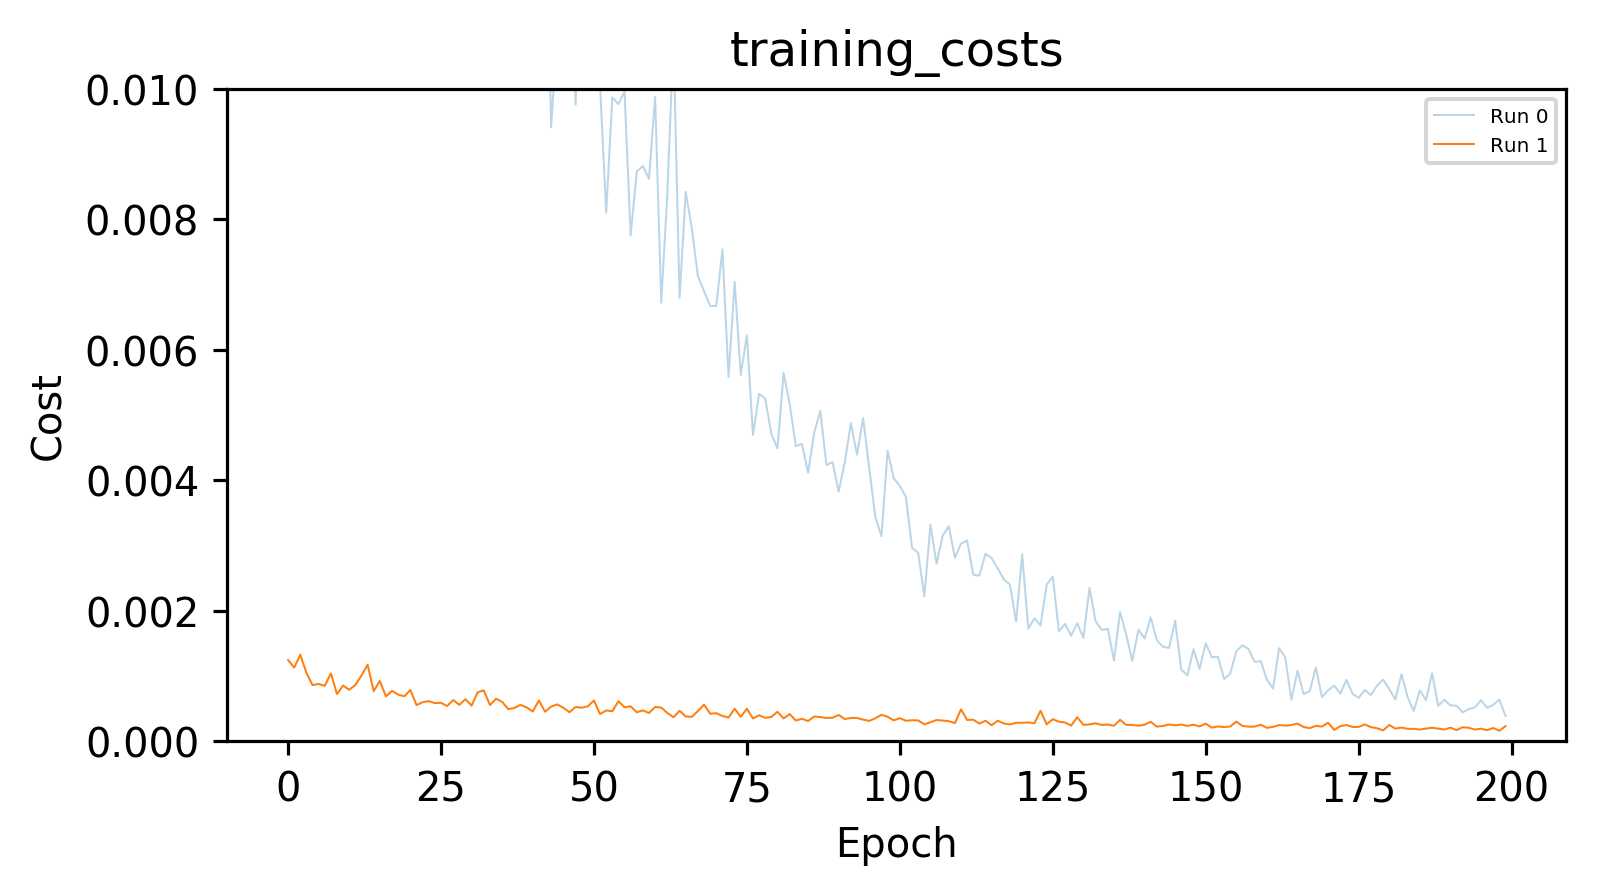

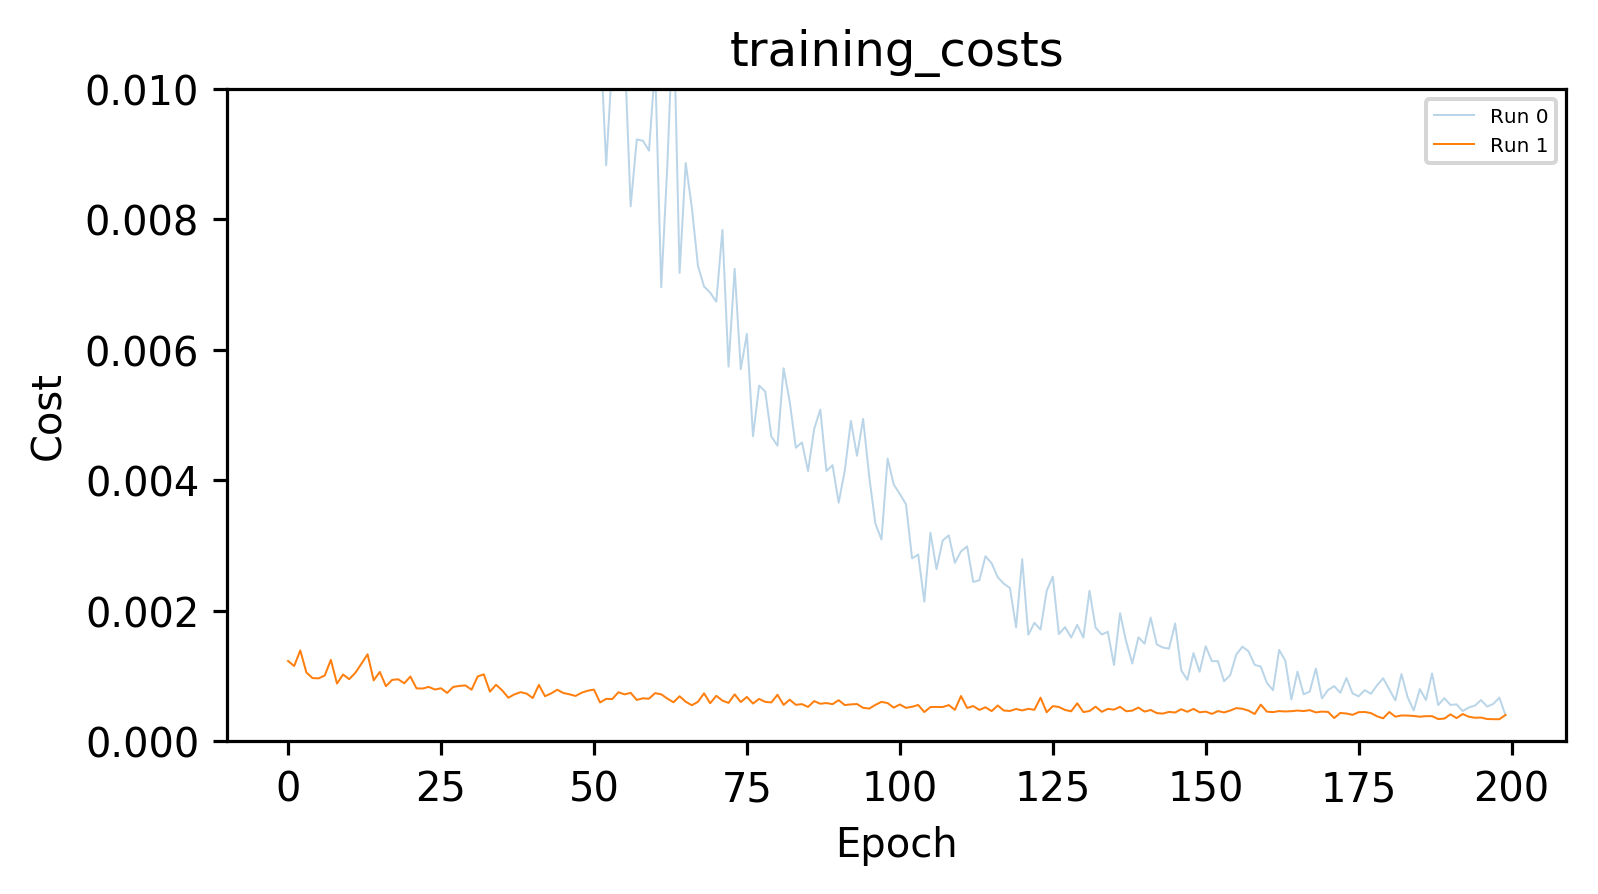

In [34]:
training_costs, testing_costs = get_costs('logs/',num_epochs)
plot_costs(training_costs, 'training_costs', ylim = [0,0.01], highlight_run = 1)
plot_costs(testing_costs, 'training_costs', ylim = [0,0.01], highlight_run = 1)

> I'd say this worked pretty well.

### View predictions

 - Cant 100% extract the images myself yet from the tensorflow event logs, so this is a screenshot from TensorBoard

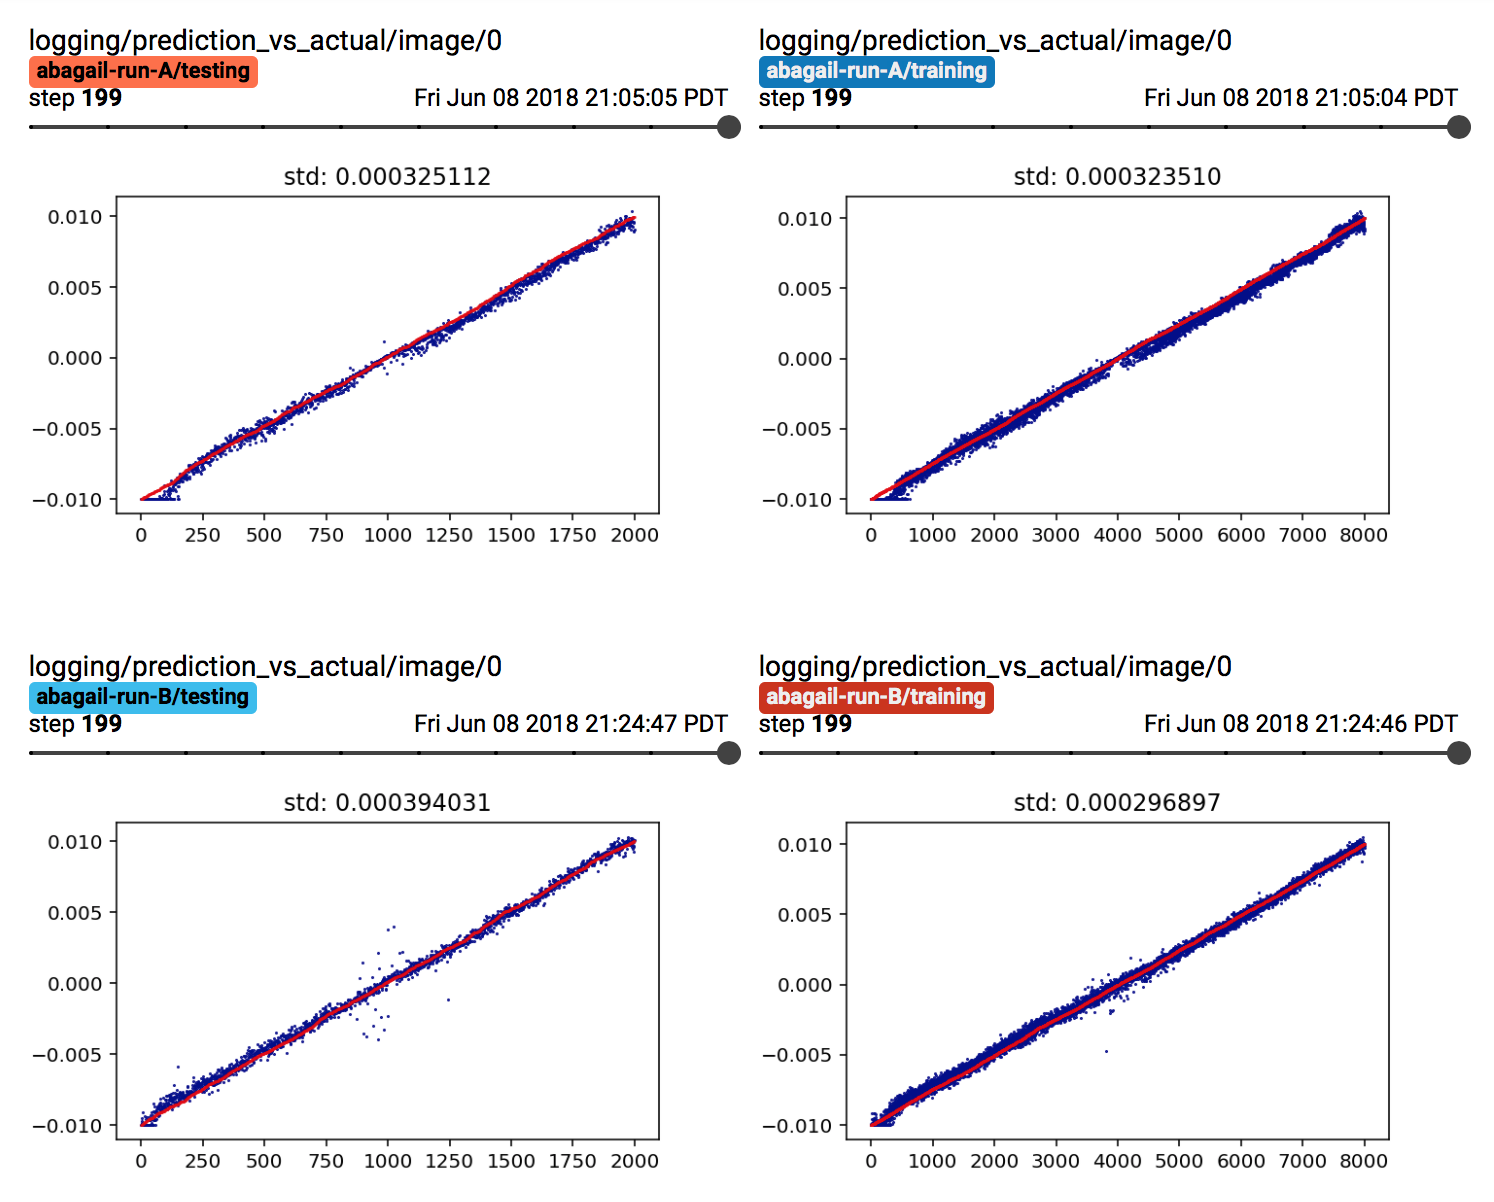

In [4]:
display(Image(filename='images/run-AB-predictions.png', embed=True, retina = True))